<a href="https://colab.research.google.com/github/funkdub/Pytorch/blob/master/ResNet_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commands Line

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive


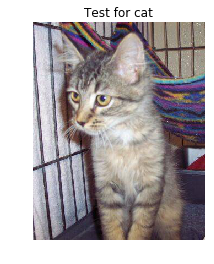

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('train/cat.2.jpg')
plt.title('Test for cat')
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
print('Importing ...')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


import os
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Importing ...


使用datasets 准备数据集，并且将训练集 验证机 以及 测试集准备好。

In [12]:
%pwd

'/gdrive/My Drive'

In [20]:
# 其实就是数据增强操作,在dataloader中使用transforms
train_transforms = transforms.Compose(
[
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop((224,224),pad_if_needed=True),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
]
)

test_transforms = transforms.Compose(
[
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
]
)

INPUT = '/gdrive/My Drive/train/'

TRAIN_DIR = 'data/train/'
VALID_DIR = 'data/valid/'
TEST_DIR = 'data/test/'

all_imgs = os.listdir

cats = [t for t in all_imgs if 'cat' in t and t.endswith('.jpg')]
dogs = [t for t in all_imgs if 'dog' in t and t.endswith('.jpg')]

random.shuffle(cats)
random.shuffle(dogs)

n_train = int(len(all_imgs)*0.8) // 2
n_valid = int(len(all_imgs)*0.1) // 2
n_test = int(len(all_imgs)*0.1) // 2

train_dogs = dogs[:n_train]
valid_dogs = dogs[n_train:n_train+n_valid]
test_dogs =  dogs[n_train+n_valid:]

train_cats = cats[:n_train]
valid_cats = cats[n_train:n_train+n_valid]
test_cats =  cats[n_train+n_valid:]

import shutil as sh

for dog in train_dogs:
  sh.move(os.path.join(INPUT,dog),os.path.join(TRAIN_DIR,'dog',dog))
for dog in valid_dogs:
  sh.move(os.path.join(INPUT,dog),os.path.join(VALID_DIR,'dog',dog))
for dog in test_dogs:
  sh.move(os.path.join(INPUT,dog),os.path.join(TEST_DIR,'dog',dog))
for cat in train_cats:
  sh.move(os.path.join(INPUT,cat),os.path.join(TRAIN_DIR,'cat',cat))
for cat in valid_cats:
  sh.move(os.path.join(INPUT,cat),os.path.join(VALID_DIR,'cat',cat))
for cat in test_cats:
  sh.move(os.path.join(INPUT,cat),os.path.join(TEST_DIR,'cat',cat))

/gdrive/My Drive/train/
train_data num is 0 |valid_data numm is  0 |test_data numm is 0


In [21]:
train_data = datasets.ImageFolder('data/train/',train_transforms)
valid_data = datasets.ImageFolder('data/valid/',test_transforms)
test_data = datasets.ImageFolder('data/test/',test_transforms)


print('train_data num is',len(train_data),'|valid_data numm is ',len(valid_data),'|test_data numm is',len(test_data))

train_data num is 7080 |valid_data numm is  884 |test_data numm is 886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


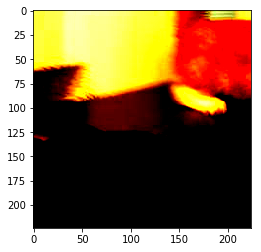

In [17]:
import matplotlib.pyplot as plt
import numpy as np
x = next(iter(train_data))

def show(img):
  img = img.numpy()
  plt.imshow(np.transpose(img,(1,2,0)))
  
print(x[0].shape)
grid = torchvision.utils.make_grid(x[0],nrow=10,padding=100)

show(grid)
show(x[0])

参数

In [0]:
BATCH_SIZE = 64

train_data_it = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
valid_data_it = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_data_it = data.DataLoader(test_data, batch_size = BATCH_SIZE)


In [0]:
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True).to(device)


In [25]:
for param in model.parameters():
  param.requires_grad = False

print(model.fc)

model.fc = nn.Linear(in_features=512,out_features=2).to(device)

optimizer = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
print(model)

Linear(in_features=512, out_features=1000, bias=True)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

计算准确率

In [0]:
def accuracy_cal(pred, y):
  # tensor.max选取 tensor中的最大值 
  # max(1)将 最大值的 index 作为结果输出
  prediction = pred.max(1)[1]
  correct = prediction.eq(y.view_as(prediction)).sum()
  acc = correct.float() / prediction.shape[0]
  return acc

In [0]:
def train(model, device , data , optimizer , loss_func):
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  
  for (x,y) in data:
    
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    pred = model(x)
    loss = loss_func(pred, y)
    acc = accuracy_cal(pred,y)
    loss.backward()
    optimizer.step()
    
    # item()将单值tensor转换成标量
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)

In [0]:
def test(model,device,data,loss_func):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  
  with torch.no_grad():
    for (x,y) in data:
      x = x.to(device)
      y = y.to(device)
      
      pred = model(x)
      loss = loss_func(pred,y)
      acc = accuracy_cal(pred,y)
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)
      

In [29]:
EPOCH = 10
SAVE_DIR = 'models'
MODEL_SAVE_DIR = os.path.join(SAVE_DIR,'ResNet_dogs_vs_cats.pt')

best_valid_loss = float('inf')


if not os.path.isdir(f'{SAVE_DIR}'):
  os.makedirs(f'{SAVE_DIR}')
  
for epoch in range(EPOCH):
  print('Epoch is ',epoch)
  train_loss , train_acc = train(model,device,train_data_it,optimizer,loss_func)
  valid_loss , valid_acc = test(model,device,valid_data_it,loss_func)
  
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),MODEL_SAVE_DIR)
  print('|EPOCH ',epoch,'|Train Loss is ',train_loss,'|Train Acc is ',train_acc,'|Valid Loss is ',valid_loss,'|Valid acc is ',valid_acc)

Epoch is  0
|EPOCH  0 |Train Loss is  0.27298379494800223 |Train Acc is  0.8840653155301068 |Valid Loss is  0.10116155126265117 |Valid acc is  0.9676339285714286
Epoch is  1
|EPOCH  1 |Train Loss is  0.15428827984912977 |Train Acc is  0.9406531533679446 |Valid Loss is  0.08662189716207129 |Valid acc is  0.9665178571428571
Epoch is  2
|EPOCH  2 |Train Loss is  0.14907699578382946 |Train Acc is  0.9369932434580348 |Valid Loss is  0.07352425730121988 |Valid acc is  0.9698660714285714
Epoch is  3
|EPOCH  3 |Train Loss is  0.13944533520990665 |Train Acc is  0.9422578827754872 |Valid Loss is  0.07149554256881986 |Valid acc is  0.9720982142857143
Epoch is  4
|EPOCH  4 |Train Loss is  0.12994917555972263 |Train Acc is  0.9494369368295412 |Valid Loss is  0.06552809476852417 |Valid acc is  0.9754464285714286
Epoch is  5
|EPOCH  5 |Train Loss is  0.126489417375745 |Train Acc is  0.9491554052980097 |Valid Loss is  0.06503267320139068 |Valid acc is  0.9754464285714286
Epoch is  6
|EPOCH  6 |Train L

In [30]:
model.load_state_dict(torch.load(MODEL_SAVE_DIR))
test_loss, test_acc = test(model,device,test_data_it,loss_func)
print('Test Loss is ',test_loss,'|Test ACC is ',test_acc)

Test Loss is  0.06807286172573056 |Test ACC is  0.980820106608527
